Making all necessary imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, datasets, metrics

Creating a multiclass classification dataset using Scikit-Learn

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
X, y = make_classification(
    n_samples = 1000,
    n_features = 20,
    n_informative = 15,
    n_redundant = 5,
    n_classes = 4,
    random_state = 42
)

X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)

print(f"X_train size: {X_train.shape}\n")
print(f"y_train size: {y_train.shape}\n")
print(f"X_test size: {X_test.shape}\n")
print(f"y_test size: {y_test.shape}\n")

X_train size: (700, 20)

y_train size: (700,)

X_test size: (300, 20)

y_test size: (300,)



OneHotEncoding to prepare data for Softmax Regression

In [5]:
def one_hot_encoder(y, num_classes):

  """
  Convert integer labels to one-hot encoded matrix.

  Parameters:
  y: numpy array of shape (n_samples,) - Integer labels
  num_classes: int - Number of classes

  Returns:
  Y: numpy array of shape (n_samples, num_classes) - One-hot Encoded Matrix
  """

  n_samples = y.shape[0]
  Y = np.zeros((n_samples, num_classes))

  Y[np.arange(n_samples), y] = 1

  return Y

Testing on Sample Data

In [6]:
num_classes = 4
Y_train = one_hot_encoder(y_train, num_classes)
Y_test = one_hot_encoder(y_test, num_classes)

print(f"Y_train size: {Y_train.shape}\n")
print(f"Y_test size: {Y_test.shape}\n")
print(f"First 5 one-hot labels:\n{Y_train[:5]}\n")
print(f"Fist 5 original labels:\n{y_train[:5]}\n")

Y_train size: (700, 4)

Y_test size: (300, 4)

First 5 one-hot labels:
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Fist 5 original labels:
[1 3 0 2 3]



Creating a numerically stable softmax

In [7]:
def softmax(logits):

  """
  Compute Softmax probabilities with numerical stability.

  Parameters:
  logits: numpy array of shape (n_samples, num_classes) - Raw scores (z = X @ w + b)

  Returns:
  probs: numpy array of shape (n_samples, num_classes) - Softmax probabilities (each row
  sums from 0 to 1)
  """

  shifted_logits = logits - np.max(logits, axis = 1, keepdims = True)
  exp_logits = np.exp(shifted_logits)
  probs = exp_logits / np.sum(exp_logits, axis = 1, keepdims = True)

  return probs

Testing on Sample Data

In [8]:
test_logits = np.random.random((3, 4))
test_probs = softmax(test_logits)

print(f"Test logits: {test_logits}\n")
print(f"Test probabilities: {test_probs}\n")
print(f"Row sums: {test_probs.sum(axis = 1)}")

Test logits: [[0.17865444 0.28491215 0.06667137 0.57217658]
 [0.62261312 0.34763529 0.42353961 0.51720541]
 [0.68645481 0.63818977 0.67040689 0.75880346]]

Test probabilities: [[0.22279853 0.24777613 0.19919512 0.33023022]
 [0.28743593 0.21833316 0.23555077 0.25868013]
 [0.24925277 0.23750828 0.24528471 0.26795423]]

Row sums: [1. 1. 1.]


Implementing the Cross-Entropy Loss Function

In [9]:
def cross_entropy_loss(Y_true, Y_pred, epsilon = 1e-15):

  """
  Computes the cross entropy loss.

  Parameters:
  Y_true: numpy array of shape (n_samples, num_classes) - One-hot encoded labels
  Y_pred: numpy array of shape (n_samples, num_classes) - Predicted probabilities
  epsilon: float - Small value to prevent log(0)

  Returns:
  loss: float - Average Cross Entropy Loss
  """

  #Clips predictions to avoid log(0)
  clipped_predictions = np.clip(Y_pred, epsilon, 1 - epsilon)

  loss = -np.mean(Y_true * np.log(clipped_predictions))

  return loss

Testing on Sample Data

In [10]:
Y_true_test = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

Y_pred_perfect = np.array([[0.99, 0.005, 0.005],
                           [0.005, 0.99, 0.005],
                           [0.005, 0.005, 0.99]])

Y_pred_random = np.array([[0.33, 0.33, 0.34],
                          [0.33, 0.33, 0.34],
                          [0.33, 0.33, 0.34]])

perfect_loss = cross_entropy_loss(Y_true_test, Y_pred_perfect)
random_loss = cross_entropy_loss(Y_true_test, Y_pred_random)

print(f"Loss with near-perfect conditions: {perfect_loss:.4f}\n")
print(f"Loss with random predictions: {random_loss:.4f}\n")

Loss with near-perfect conditions: 0.0034

Loss with random predictions: 0.3662



Creating a function to initialize parameters

In [11]:
def init_params(n_features, n_classes, seed = 42):

  """
  Initialize the weights and biases.

  Parameters:
  n_features: int - Number of input features
  n_classes: int - Number of output classes
  seed: int - Random seed

  Returns:
  W: numpy array of shape (n_features, n_classes) - Weight matrix
  b: numpy array of shape (n_classes,) - Bias Vector
  """

  np.random.seed(seed)

  #Initalize weights with a small random value

  W = np.random.randn(n_features, n_classes) * 0.001
  b = np.zeros(n_classes)

  return W, b

Testing on Sample Input Data

In [12]:
n_features = X_train.shape[1]
n_classes = 4

W, b = init_params(n_features, n_classes)

print(f"W shape: {W.shape}\n")
print(f"b shape: {b.shape}\n")
print(f"W sample values:\n{W[:3, :2]}")

W shape: (20, 4)

b shape: (4,)

W sample values:
[[ 0.00049671 -0.00013826]
 [-0.00023415 -0.00023414]
 [-0.00046947  0.00054256]]


Implementing the forward pass function

In [13]:
def forward_pass(X, W, b):

  """
  Compute forward pass (logits and probabilities)

  Parameters:
  X: numpy array of shape (n_samples, n_features) - Input features
  W: numpy array of shape (n_features, n_classes) - Weight matrix
  b: numpy array of shape (n_classes,) - Bias Vector

  Returns:
  logits: numpy array of shape (n_samples, n_classes) - Raw scores
  probabs: numpy array of shape (n_samples, n_classes) - Softmax probabilities
  """

  #Computing logits

  logits = X @ W + b

  #Applying softmax function to get probabilities

  probabs = softmax(logits)

  return logits, probabs

Testing on sample data

In [20]:
logits, probabs = forward_pass(X_train[:100], W, b)

print(f"logits shape: {logits.shape}\n")
print(f"probabs shape: {probabs.shape}\n")
print(f"First sample probabilities: {probabs[0]}\n")
print(f"Sum of probabilities: {probabs[0].sum()}\n")
print(f"Initial loss on first 5 samples: {cross_entropy_loss(Y_train[:100], probabs)}")

logits shape: (100, 4)

probabs shape: (100, 4)

First sample probabilities: [0.24740916 0.24996491 0.24817246 0.25445348]

Sum of probabilities: 0.9999999999999999

Initial loss on first 5 samples: 0.34725388745429675


Compute Gradients

In [21]:
def grad(X, Y_true, Y_pred):

  """
  Compute gradient of loss w.r.t W and b

  Parameters:
  X: numpy array of shape (n_samples, n_features) - Input Features
  Y_true: numpy array of shape (n_samples, n_classes) - One-hot encoded true labels
  Y_pred: numpy array of shape (n_samples, n_classes) - Predicted probabilities

  Returns:
  grad_W: numpy array of shape (n_features, n_classes) - Gradient w.r.t W
  grad_b: numpy array of shape (n_classes,) - Gradient w.r.t b
  """

  n_samples = X.shape[0]

  error = Y_pred - Y_true

  grad_W = (1/n_samples) * np.transpose(X) @ error
  grad_b = np.mean(error, axis = 0)

  return grad_W, grad_b

Testing on Sample Data

In [22]:
dW, db = grad(X_train[:100], Y_train[:100], probabs[:100])

print(f"dW shape: {dW.shape}\n")
print(f"db shape: {db.shape}\n")
print(f"Grad magnitudes:\n")
print(f"||dW|| = {np.linalg.norm(dW):.4f}\n")
print(f"||db|| = {np.linalg.norm(db):.4f}")

dW shape: (20, 4)

db shape: (4,)

Grad magnitudes:

||dW|| = 2.0130

||db|| = 0.1156


Regularization Functions (L2, L1 and Elastic Net)

In [23]:
def compute_regularization(W, reg_type = 'l2', lambda_reg = 0.01, l1_ratio = 0.5):

  """
  Computes regularization penalty and gradient.

  Parameters:
  W: numpy array of shape (n_features, n_classes) - Weight matrix
  reg_type: str - 'l2', 'l1', 'elastic_net' or 'none'
  lambda_reg: float - Regularization strength
  l1_ratio: float - For elatic net (balance between L1 and L2 [0 = pure L2, 1 = pure L1])

  Returns:
  reg_loss: float - Regularization loss
  reg_grad: numpy array of shape (n_features, n_classes) - Gradient of regularization w.r.t W
  """

  if reg_type == "none":
    return 0.0, np.zeros_like(W)

  elif reg_type == "l2":

    reg_loss = (lambda_reg/2) * np.sum(W ** 2)
    reg_grad = lambda_reg * W

  elif reg_type == "l1":

    reg_loss = lambda_reg * np.sum(np.abs(W))
    reg_grad = lambda_reg * np.sign(W)

  elif reg_type == "elastic_net":

    reg_loss = (l1_ratio * (lambda_reg * np.sum(np.abs(W)))) + ((1 - l1_ratio) * (lambda_reg/2) * np.sum(W ** 2))
    reg_grad = (l1_ratio * lambda_reg * np.sign(W)) +((1 - l1_ratio) * lambda_reg * W)

  else:

     raise ValueError(f"Unknown regularization type: {reg_type}")

  return reg_loss, reg_grad

Testing on Sample Data

In [26]:
W_test = np.random.randn(5, 3)

l2_loss, l2_grad = compute_regularization(W_test, reg_type = 'l2', lambda_reg = 0.1)
print(f"L2 Loss: {l2_loss:.4f}\n")
print(f"L2 Gradient Shape: {l2_grad.shape}\n")

l1_loss, l1_grad = compute_regularization(W_test, reg_type = 'l1', lambda_reg = 0.1)
print(f"L1 Loss: {l1_loss:.4f}\n")
print(f"L1 Gradient Shape: {l1_grad.shape}\n")

elastic_loss, elastic_grad = compute_regularization(W_test, reg_type = 'elastic_net', lambda_reg = 0.1, l1_ratio = 0.5)
print(f"Elastic Loss: {elastic_loss:.4f}\n")
print(f"Elastic Gradient Shape: {elastic_grad.shape}\n")

L2 Loss: 0.9425

L2 Gradient Shape: (5, 3)

L1 Loss: 1.3153

L1 Gradient Shape: (5, 3)

Elastic Loss: 1.1289

Elastic Gradient Shape: (5, 3)



Implementing Class Rebalance (Loss Reweighting)

In [27]:
def compute_class_weights(y, method = 'balanced'):

  """
  Compute class weights for imbalanced datasets.

  Parameters:
  y: numpy array of shape (n_samples,) - Integer labels
  method: str -
              'balanced' - inversely proportional to class frequencies
              'custom' - to be added later

  Returns:
  weights: numpy array of shape (n_classes,) - Weights for each class
  """

  n_samples = len(y)
  classes = np.unique(y)
  n_classes = len(classes)

  if method == "balanced":

    class_freq = np.bincount(y) #Count occurances
    weights = n_samples/(n_classes * class_freq)

  return weights

Modified cross-entropy to accept weights

In [30]:
def cross_entropy_loss_weighted(Y_true, Y_pred, class_weights = None, epsilon = 1e-15):

  """
  Compute weighted cross-entropy loss.

  Parameters:
  Y_true: numpy array of shape (n_samples, n_classes) - One-hot encoded true labels
  Y_pred: numpy array of shape (n_samples, n_classes) - Predicted
  class_weights: numpy array of shape (n_classes,) or None - Weights for each class
  epsilon: float - Small value to avoid log(0)

  Returns:
  loss: float - Weighted cross-entropy loss
  """

  Y_pred_clipped = np.clip(Y_pred, epsilon, 1 - epsilon)

  if class_weights is None:
    loss = -np.mean(Y_true * np.log(Y_pred_clipped))

  else:

    sample_weights = Y_true @ class_weights
    loss = -np.mean(sample_weights * np.sum(Y_true * np.log(Y_pred_clipped), axis = 1))

  return loss

Testing on Sample Data

In [32]:
y_imbalanced = np.array([0]*50 + [1]*30 + [2]*15 + [3]*5)
print(f"Class distribution: {np.bincount(y_imbalanced)}")

weights = compute_class_weights(y_imbalanced)
print(f"\nClass weights: {weights}")


Y_imb = one_hot_encoder(y_imbalanced, 4)
Y_pred_test = softmax(np.random.randn(100, 4))

loss_regular = cross_entropy_loss(Y_imb, Y_pred_test)
loss_weighted = cross_entropy_loss_weighted(Y_imb, Y_pred_test, weights)

print(f"\nRegular loss: {loss_regular:.4f}")
print(f"Weighted loss: {loss_weighted:.4f}")

Class distribution: [50 30 15  5]

Class weights: [0.5        0.83333333 1.66666667 5.        ]

Regular loss: 0.4788
Weighted loss: 1.7255


Implementing Focal Loss

In [33]:
def focal_loss(Y_true, Y_pred, gamma = 2.0, alpha = None, epsilon = 1e-15):

  """
  Compute Focal Loss for handling class imbalance

  Parameters:
  Y_true: numpy array of shape (n_samples, n_classes) - One-hot encoded labels
  Y_pred: numpy array of shape (n_samples, n_classes) - Predicted probabilities
  gamma: float - Focussing parameter (default is 2.0)
  alpha: numpy array of shape (n_classes,) or None - Class weights
  epsilon: float - Small value to avoid log(0)

  Returns:
  loss: float - Focal loss
  """

  Y_focal_pred_clipped = np.clip(Y_pred, epsilon, 1 - epsilon)

  y_true_prob = np.sum(Y_true * Y_focal_pred_clipped, axis = 1)

  focal_term = (1 - y_true_prob) ** gamma

  ce_term = -np.log(y_true_prob)

  f_loss = focal_term * ce_term

  if alpha is not None:

    sample_weights = Y_true @ alpha
    f_loss = sample_weights * f_loss
    return np.mean(f_loss)


  return np.mean(f_loss)

Testing on Sample Data

In [34]:
Y_pred_easy = np.array([[0.9, 0.05, 0.03, 0.02]])
Y_pred_hard = np.array([[0.4, 0.3, 0.2, 0.1]])
Y_true_test = np.array([[1, 0, 0, 0]])


ce_easy = cross_entropy_loss(Y_true_test, Y_pred_easy)
ce_hard = cross_entropy_loss(Y_true_test, Y_pred_hard)


fl_easy = focal_loss(Y_true_test, Y_pred_easy, gamma=2.0)
fl_hard = focal_loss(Y_true_test, Y_pred_hard, gamma=2.0)

print("Cross-Entropy:")
print(f"Easy example: {ce_easy:.4f}")
print(f"Hard example: {ce_hard:.4f}")
print(f"Ratio (hard/easy): {ce_hard/ce_easy:.2f}x")

print("\nFocal Loss (gamma=2):")
print(f"Easy example: {fl_easy:.4f}")
print(f"Hard example: {fl_hard:.4f}")
print(f"Ratio (hard/easy): {fl_hard/fl_easy:.2f}x")

Cross-Entropy:
Easy example: 0.0263
Hard example: 0.2291
Ratio (hard/easy): 8.70x

Focal Loss (gamma=2):
Easy example: 0.0011
Hard example: 0.3299
Ratio (hard/easy): 313.08x


Implementing Early Stopping Mechanism

In [35]:
class EarlyStopping:

  """
  Early stopping to stop training when validation loss stops improving.
  """

  def __init__(self, patience = 10, min_delta = 1e-4):

    """
    Parameters:
    patience: int - Number of epochs to wait before stopping
    min_delta: float - Minimum change in validation loss to qualify as improvement
    """

    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
    self.best_weights = None

  def __call__(self, val_loss, W, b):

    """
    Check if training should stop.

    Parameters:
    val_loss: float - Current Validation loss
    W, b: numpy array - Current model parameters

    Returns:
    should_stop: bool - True if training should stop.
    """

    if self.best_loss is None:

      self.best_loss = val_loss
      self.best_weights = (W.copy(), b.copy())
      return False

    elif val_loss < self.best_loss - self.min_delta:

      self.best_loss = val_loss
      self.best_weights = (W.copy(), b.copy())
      self.counter = 0
      return False

    else:

      self.counter += 1
      if self.counter >= self.patience:

        self.early_stop = True
        return True
      else:
        return False

    return self.early_stop

  def restore_best_weights(self):

    """
    Return best weights found during training.
    """

    return self.best_weights

Testing on Sample Data

In [36]:
early_stop = EarlyStopping(patience=3, min_delta=0.001)

losses = [1.5, 1.3, 1.2, 1.25, 1.24, 1.23, 1.22, 1.21]
W_test, b_test = np.random.randn(5, 3), np.random.randn(3)

for epoch, loss in enumerate(losses):
    should_stop = early_stop(loss, W_test, b_test)
    print(f"Epoch {epoch+1}: Val Loss = {loss:.2f}, Counter = {early_stop.counter}, Stop = {should_stop}")
    if should_stop:
        print("Early stopping triggered!")
        break

Epoch 1: Val Loss = 1.50, Counter = 0, Stop = False
Epoch 2: Val Loss = 1.30, Counter = 0, Stop = False
Epoch 3: Val Loss = 1.20, Counter = 0, Stop = False
Epoch 4: Val Loss = 1.25, Counter = 1, Stop = False
Epoch 5: Val Loss = 1.24, Counter = 2, Stop = False
Epoch 6: Val Loss = 1.23, Counter = 3, Stop = True
Early stopping triggered!


Creating a visualization function to visualize training loss.

In [38]:
def plot_loss_history(history, title = "Loss History"):

  """
  Plot loss and accuracy curves.

  Parameters:
  history: dict - Dictionary with 'train_loss', 'val_loss', 'train_acc', and 'val_acc' lists.
  title: str - Title of the plot (default is "Loss History").
  """

  fig, axes = plt.subplots(1, 2, figsize = (14, 5))

  #Plot 1: Loss
  axes[0].plot(history['train_loss'], label = 'Train')
  axes[0].plot(history['val_loss'], label = 'Validation')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss History')
  axes[0].legend()

  #Plot 2: Accuracy
  axes[1].plot(history['train_acc'], label = 'Train')
  axes[1].plot(history['val_acc'], label = 'Validation')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy History')
  axes[1].legend()

  plt.tight_layout()
  plt.show()

Completing the training loop.

In [41]:
def train(X_train, Y_train, X_val, Y_val,
          n_classes,
          learning_rate = 0.01,
          n_epochs = 1000,
          reg_type = 'l2',
          lambda_reg = 0.01,
          l1_ratio = 0.5,
          loss_type = 'cross_entropy',
          class_weights = None,
          focal_gamma = 2.0,
          focal_alpha = None,
          early_stopping = None,
          verbose = True):

  """
  Train softmax regression.

  Returns:
  W, b: numpy arrays of trained parameters
  history: dict - Dictionary with training history.
  """

  n_features = X_train.shape[1]

  W, b = init_params(n_features, n_classes)

  #Initialize training history
  history = {
      'train_loss': [],
      'val_loss': [],
      'train_acc': [],
      'val_acc': []
  }

  for epoch in range(n_epochs):

    #1. Forward pass

    logits_train, probab_train = forward_pass(X_train, W, b)

    #2. Compute loss

    if loss_type == 'cross_entropy':

      loss_train = cross_entropy_loss_weighted(Y_train, probab_train)

    elif loss_type == 'weighted':

      loss_train = cross_entropy_loss_weighted(Y_train, probab_train, class_weights)

    elif loss_type == 'focal':

      loss_train = focal_loss(Y_train, probab_train, gamma = focal_gamma, alpha = focal_alpha)

    else:

      raise ValueError(f"Unknown loss type: {loss_type}")

    #3. Add regularization to loss

    reg_loss, reg_grad = compute_regularization(W, reg_type = reg_type, lambda_reg = lambda_reg, l1_ratio = l1_ratio)

    loss_train += reg_loss

    #4. Compute Gradients

    dW, db = grad(X_train, Y_train, probab_train)

    #5. Update parameters

    W -= learning_rate * (dW + reg_grad)
    b -= learning_rate * db

    #6. Compute training accuracy

    predictions = np.argmax(probab_train, axis = 1)
    true_labels = np.argmax(Y_train, axis = 1)
    train_acc = np.mean(predictions == true_labels)

    #7. Forward pass on validation data

    logits_val, probab_val = forward_pass(X_val, W, b)

    #8. Compute validation loss

    if loss_type == 'cross_entropy':

      loss_val = cross_entropy_loss_weighted(Y_val, probab_val)

    elif loss_type == 'weighted':

      loss_val = cross_entropy_loss_weighted(Y_val, probab_val, class_weights)

    elif loss_type == 'focal':

      loss_val = focal_loss(Y_val, probab_val, gamma = focal_gamma, alpha = focal_alpha)

    else:

      raise ValueError(f"Unknown loss type: {loss_type}")

    #9. Compute Validation Accuracy

    predictions_val = np.argmax(probab_val, axis = 1)
    true_labels_val = np.argmax(Y_val, axis = 1)
    val_acc = np.mean(predictions_val == true_labels_val)

    #10. Record History

    history['train_loss'].append(loss_train)
    history['val_loss'].append(loss_val)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    #11. Early Stopping Check

    if early_stopping is not None:

      if early_stopping(loss_val, W, b):
        print(f"Early stopping at epoch {epoch+1}.")
        W, b = early_stopping.restore_best_weights()
        break

    if verbose and (epoch + 1) % 20 == 0:

      print(f"Epoch {epoch + 1}/{n_epochs} - "
            f"Train Loss: {loss_train:.4f} - "
            f"Val Loss: {loss_val:.4f} - "
            f"Training Accuracy: {train_acc:.4f} - "
            f"Validation Accuracy: {val_acc:.4f}")

  return W, b, history

Testing on Sample Data

In [39]:
X_train_split, X_val, Y_train_split, Y_val = tts(
    X_train, Y_train,
    test_size=0.2,
    random_state=42
)

print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (560, 20)
Validation set: (140, 20)
Test set: (300, 20)


Epoch 20/500 - Train Loss: 0.2149 - Val Loss: 0.2154 - Training Accuracy: 0.6536 - Validation Accuracy: 0.6643
Epoch 40/500 - Train Loss: 0.2082 - Val Loss: 0.2138 - Training Accuracy: 0.6411 - Validation Accuracy: 0.6571
Early stopping at epoch 55.


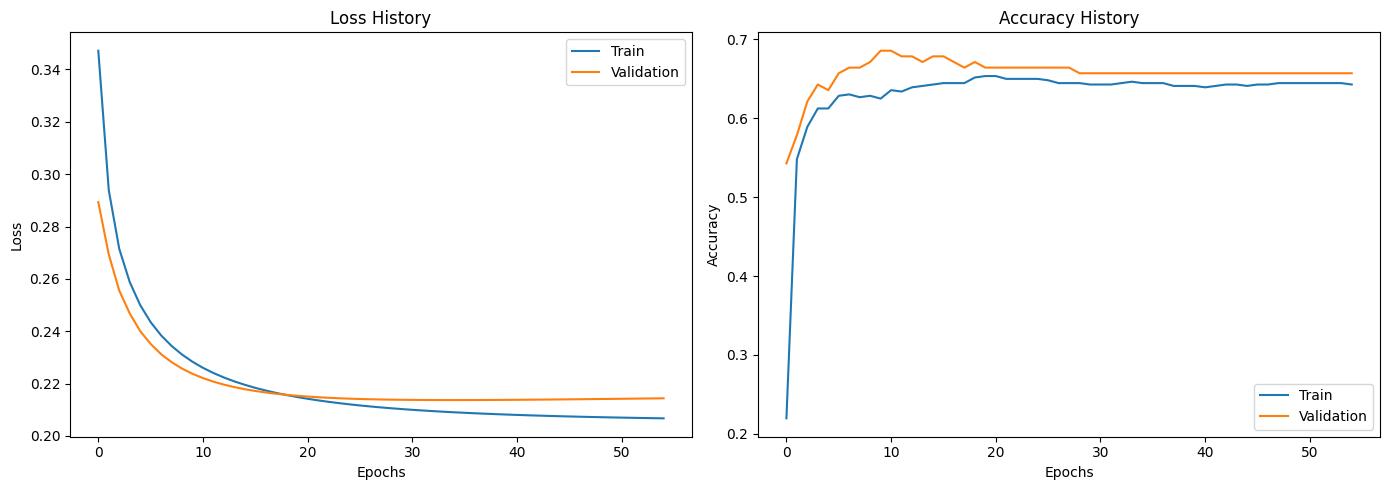

In [42]:
early_stop = EarlyStopping(patience = 30, min_delta = 0.001)

W_baseline, b_baseline, history_baseline = train(
    X_train_split, Y_train_split,
    X_val, Y_val,
    n_classes = 4,
    learning_rate = 0.1,
    n_epochs = 500,
    reg_type = 'none',
    loss_type = 'cross_entropy',
    early_stopping = early_stop,
    verbose = True
)


plot_loss_history(history_baseline, title = "Baseline Model")

Epoch 20/500 - Train Loss: 0.2182 - Val Loss: 0.2155 - Training Accuracy: 0.6518 - Validation Accuracy: 0.6714
Epoch 40/500 - Train Loss: 0.2132 - Val Loss: 0.2137 - Training Accuracy: 0.6411 - Validation Accuracy: 0.6571
Early stopping at epoch 55.


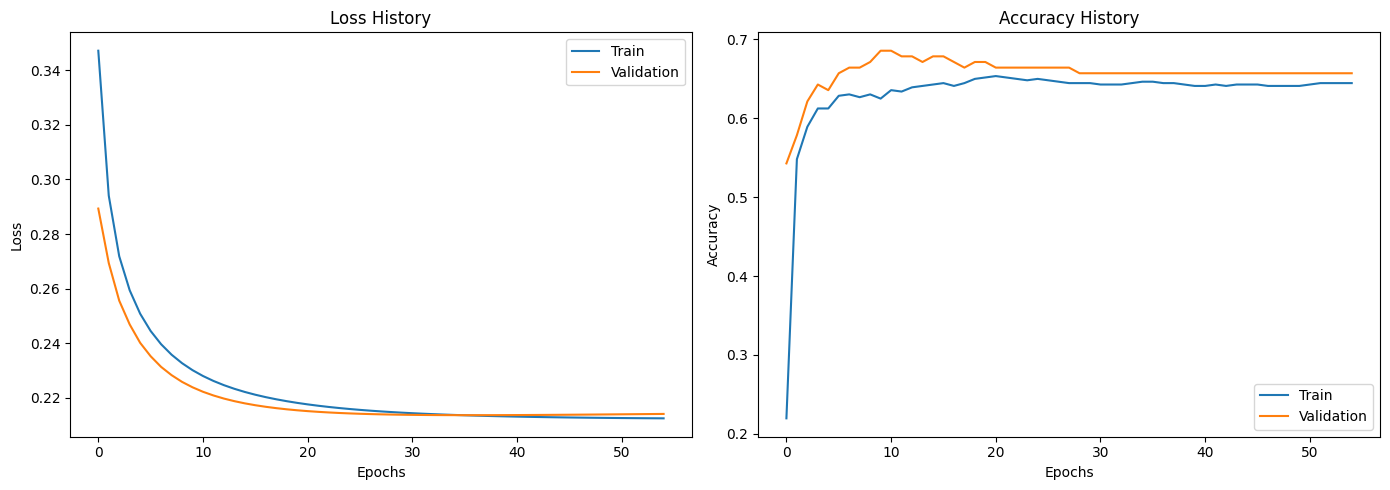

In [43]:
early_stop_l2 = EarlyStopping(patience = 30, min_delta = 0.001)

W_l2, b_l2, history_l2 = train(
    X_train_split, Y_train_split,
    X_val, Y_val,
    n_classes = 4,
    learning_rate = 0.1,
    n_epochs = 500,
    reg_type = 'l2',
    lambda_reg = 0.01,
    loss_type = 'cross_entropy',
    early_stopping = early_stop_l2,
    verbose = True
)

plot_loss_history(history_l2, title = "L2 Regularization")

Epoch 20/500 - Train Loss: 0.2667 - Val Loss: 0.2167 - Training Accuracy: 0.6482 - Validation Accuracy: 0.6714
Epoch 40/500 - Train Loss: 0.2687 - Val Loss: 0.2137 - Training Accuracy: 0.6500 - Validation Accuracy: 0.6571
Epoch 60/500 - Train Loss: 0.2699 - Val Loss: 0.2136 - Training Accuracy: 0.6464 - Validation Accuracy: 0.6714
Early stopping at epoch 62.


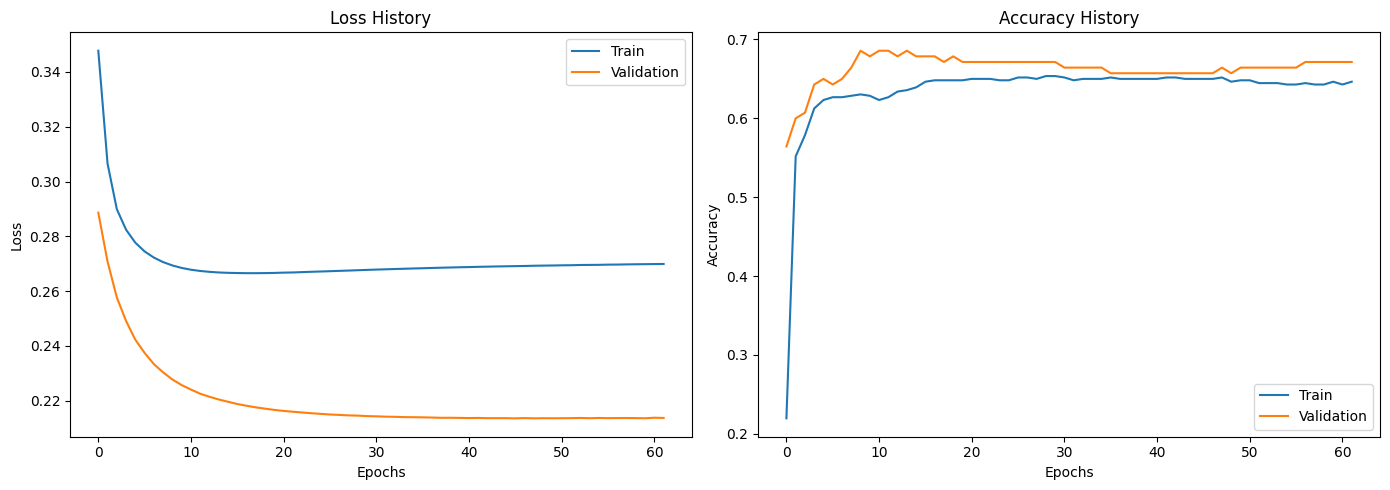

In [50]:
early_stop_l1 = EarlyStopping(patience = 30, min_delta = 0.001)

W_l1, b_l1, history_l1 = train(
    X_train_split, Y_train_split,
    X_val, Y_val,
    n_classes = 4,
    learning_rate = 0.1,
    n_epochs = 500,
    reg_type = 'l1',
    lambda_reg = 0.01,
    loss_type = 'cross_entropy',
    early_stopping = early_stop_l1,
    verbose = True
)

plot_loss_history(history_l1, title = "L1 Regularization")

Epoch 20/500 - Train Loss: 0.2439 - Val Loss: 0.2160 - Training Accuracy: 0.6500 - Validation Accuracy: 0.6786
Epoch 40/500 - Train Loss: 0.2433 - Val Loss: 0.2134 - Training Accuracy: 0.6446 - Validation Accuracy: 0.6643
Epoch 60/500 - Train Loss: 0.2440 - Val Loss: 0.2136 - Training Accuracy: 0.6375 - Validation Accuracy: 0.6643
Early stopping at epoch 65.


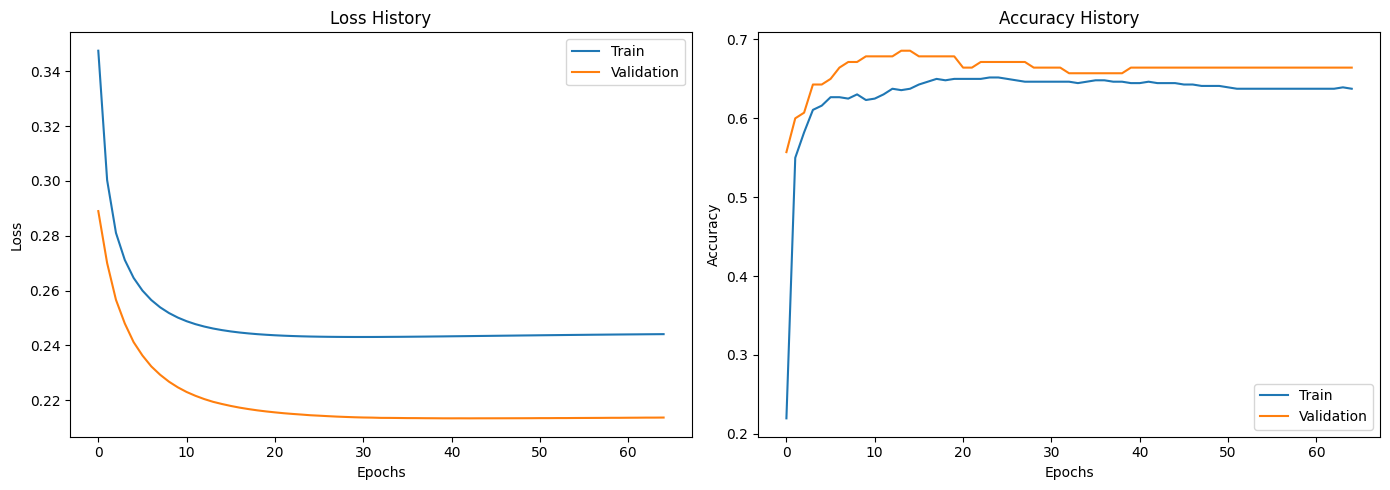

In [51]:
early_stop_enet = EarlyStopping(patience = 30, min_delta = 0.001)

W_enet, b_enet, history_enet = train(
    X_train_split, Y_train_split,
    X_val, Y_val,
    n_classes = 4,
    learning_rate = 0.1,
    n_epochs = 500,
    reg_type = 'elastic_net',
    lambda_reg = 0.01,
    l1_ratio = 0.5,
    loss_type = 'cross_entropy',
    early_stopping = early_stop_enet,
    verbose = True
)

plot_loss_history(history_enet, title = "Elastic Net Regularization")

Epoch 20/500 - Train Loss: 0.4183 - Val Loss: 0.4473 - Training Accuracy: 0.6518 - Validation Accuracy: 0.6714
Early stopping at epoch 39.


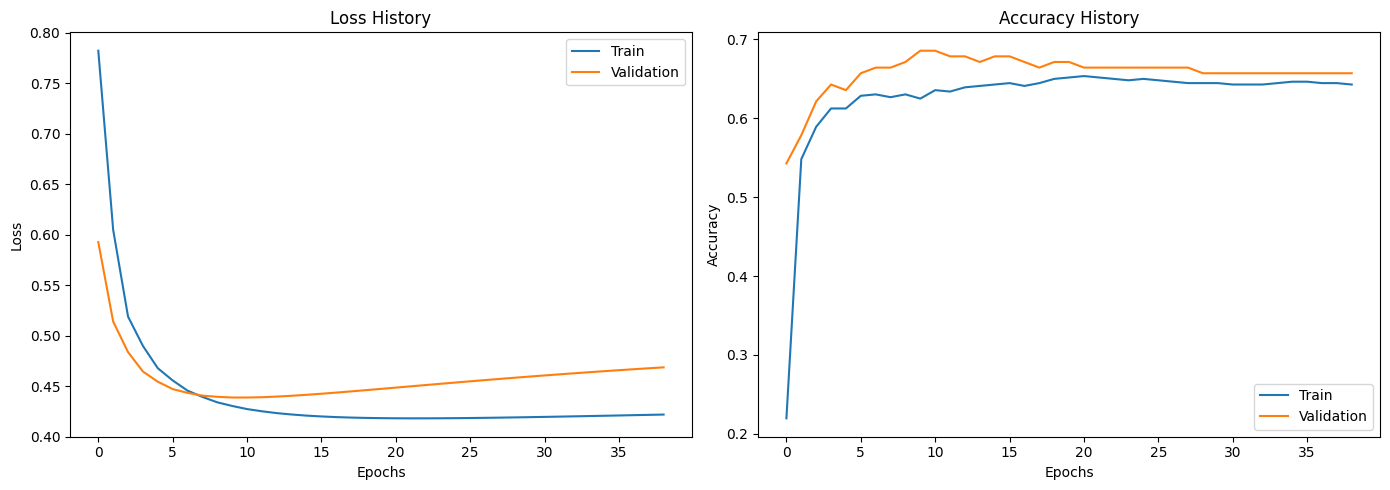

In [52]:
early_stop_l2_focal = EarlyStopping(patience = 30, min_delta = 0.001)

W_l2_focal, b_l2_focal, history_l2_focal = train(
    X_train_split, Y_train_split,
    X_val, Y_val,
    n_classes = 4,
    learning_rate = 0.1,
    n_epochs = 500,
    reg_type = 'l2',
    lambda_reg = 0.01,
    loss_type = 'focal',
    early_stopping = early_stop_l2_focal,
    verbose = True
)

plot_loss_history(history_l2_focal, title = "L2 Regularization w/ Focal Loss")

Comparing the different models

In [53]:
def compare_models(histories, labels, metric = 'loss'):

    """
    Compare multiple models on the same plot

    Parameters:
    histories : list of dicts - List of history dictionaries from different models
    labels : list of str - Labels for each model
    metric : str - 'loss' or 'accuracy'
    """

    plt.figure(figsize = (14, 6))

    plt.subplot(1, 2, 1)

    for history, label in zip(histories, labels):

        if metric == 'loss':
            plt.plot(history['train_loss'], label = label)

        else:
            plt.plot(history['train_acc'], label = label)

    plt.xlabel('Epochs')
    plt.ylabel(f'Training {metric.capitalize()}')
    plt.title(f'Training {metric.capitalize()} Comparison')
    plt.legend()
    plt.grid(True, alpha = 0.3)

    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):

        if metric == 'loss':
            plt.plot(history['val_loss'], label = label)

        else:
            plt.plot(history['val_acc'], label = label)

    plt.xlabel('Epochs')
    plt.ylabel(f'Validation {metric.capitalize()}')
    plt.title(f'Validation {metric.capitalize()} Comparison')
    plt.legend()
    plt.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()


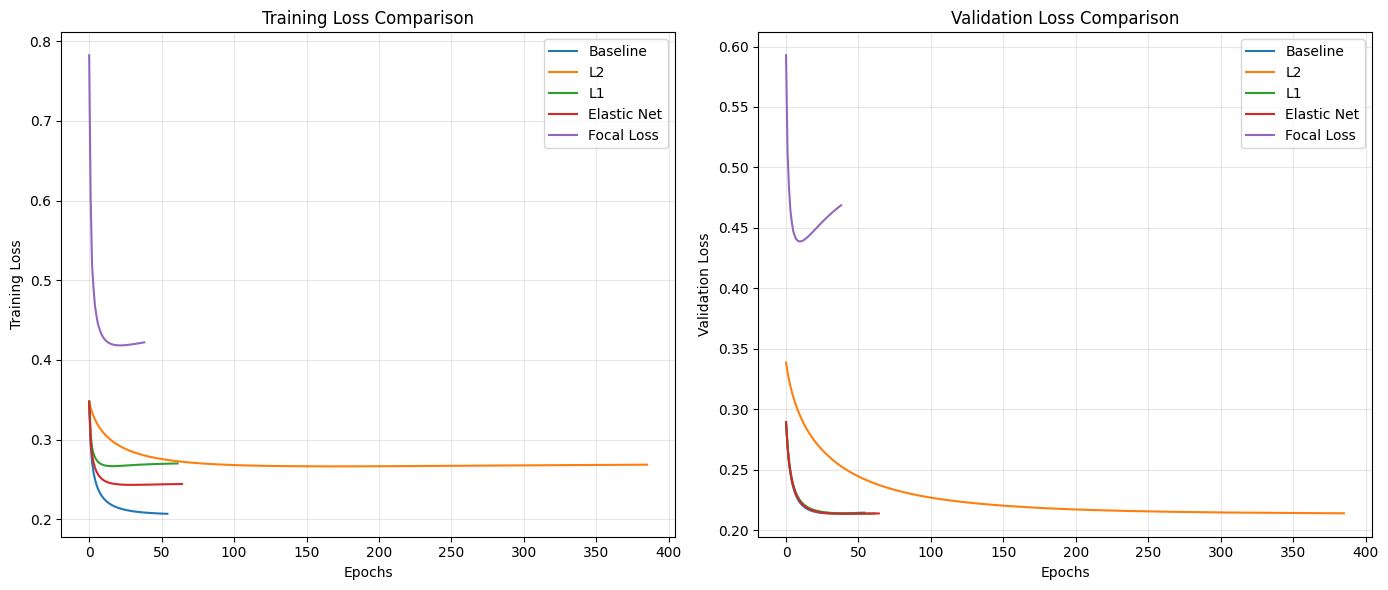

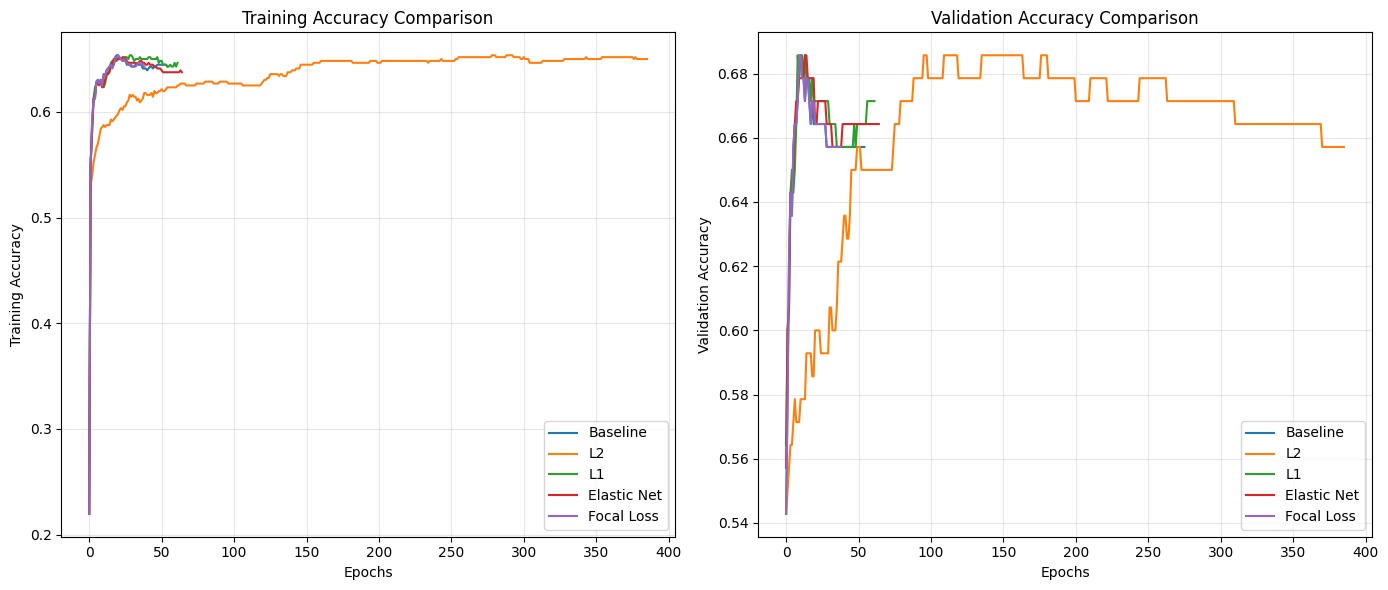

In [54]:
histories = [history_baseline, history_l2, history_l1, history_enet, history_l2_focal]

labels = ['Baseline', 'L2', 'L1', 'Elastic Net', 'Focal Loss']


compare_models(histories, labels, metric = 'loss')

compare_models(histories, labels, metric = 'accuracy')

Final Evaluation on Test Set

In [55]:
def evaluate_model(W, b, X_test, y_test):

    """
    Evaluate model on test set

    Returns:
    accuracy : float
    predictions : array
    """

    _, probs = forward_pass(X_test, W, b)
    predictions = np.argmax(probs, axis = 1)
    accuracy = np.mean(predictions == y_test)
    return accuracy, predictions

models = {
    'Baseline': (W_baseline, b_baseline),
    'L2': (W_l2, b_l2),
    'L1': (W_l1, b_l1),
    'Elastic Net': (W_enet, b_enet),
    'Focal Loss': (W_l2_focal, b_l2_focal)
    }

for name, (W, b) in models.items():
    print(f'Evaluating model: {name}')
    acc, preds = evaluate_model(W, b, X_test, y_test)
    print(f"{name:15s}: {acc:.4f} ({acc*100:.2f}%)")

Evaluating model: Baseline
Baseline       : 0.5800 (58.00%)
Evaluating model: L2
L2             : 0.5733 (57.33%)
Evaluating model: L1
L1             : 0.5933 (59.33%)
Evaluating model: Elastic Net
Elastic Net    : 0.5733 (57.33%)
Evaluating model: Focal Loss
Focal Loss     : 0.5933 (59.33%)


Confusion Matrix and Final Analysis

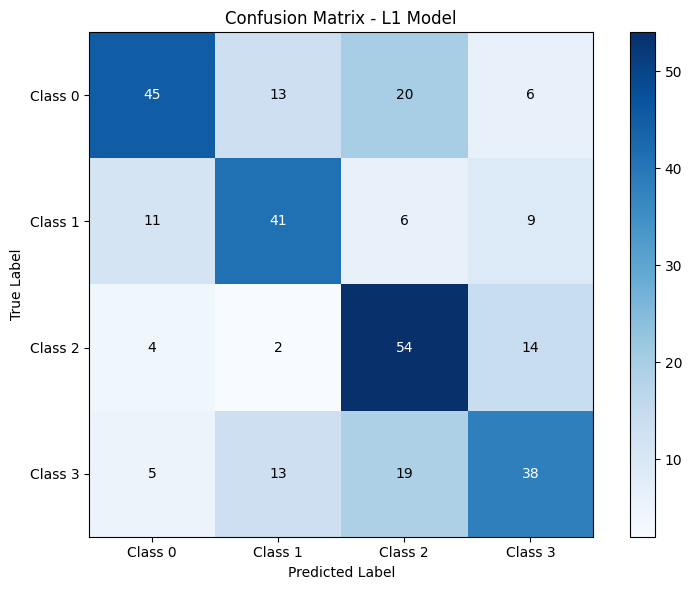


Classification Report (L1 Model):
              precision    recall  f1-score   support

     Class 0       0.69      0.54      0.60        84
     Class 1       0.59      0.61      0.60        67
     Class 2       0.55      0.73      0.62        74
     Class 3       0.57      0.51      0.54        75

    accuracy                           0.59       300
   macro avg       0.60      0.60      0.59       300
weighted avg       0.60      0.59      0.59       300



In [56]:
def plot_confusion_matrix(y_true, y_pred, title = "Confusion Matrix"):

    """
    Plot confusion matrix
    """

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = 'Blues')
    plt.title(title)
    plt.colorbar()


    tick_marks = np.arange(4)
    plt.xticks(tick_marks, [f'Class {i}' for i in range(4)])
    plt.yticks(tick_marks, [f'Class {i}' for i in range(4)])

    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):

        for j in range(cm.shape[1]):

            plt.text(j, i, format(cm[i, j], 'd'),
                    ha = "center", va = "center",
                    color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

_, preds_l1 = evaluate_model(W_l1, b_l1, X_test, y_test)
plot_confusion_matrix(y_test, preds_l1, title = "Confusion Matrix - L1 Model")

print("\nClassification Report (L1 Model):")
print(classification_report(y_test, preds_l1, target_names = [f'Class {i}' for i in range(4)]))

# **Benchmarking against Scikit-Learn**

Loading the MNIST Dataset

In [57]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

mnist = fetch_openml('mnist_784', version = 1, parser = 'auto')
X_mnist, y_mnist = mnist.data, mnist.target

X_mnist = np.array(X_mnist, dtype = np.float32)
y_mnist = np.array(y_mnist, dtype = np.int32)

print(f"MNIST shape: {X_mnist.shape}")
print(f"Labels shape: {y_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

n_samples = 10000
indices = np.random.RandomState(42).choice(len(X_mnist), n_samples, replace=False)
X_mnist_subset = X_mnist[indices]
y_mnist_subset = y_mnist[indices]

print(f"\nUsing {n_samples} samples")
print(f"Class distribution: {np.bincount(y_mnist_subset)}")

MNIST shape: (70000, 784)
Labels shape: (70000,)
Number of classes: 10

Using 10000 samples
Class distribution: [ 983 1152  967 1034  906  937  961 1055  969 1036]


Preparring the dataset

In [58]:
X_train_mnist, X_temp, y_train_mnist, y_temp = tts(
    X_mnist_subset, y_mnist_subset,
    test_size = 0.3,
    random_state = 42,
    stratify = y_mnist_subset
)

# Second split: split temp into 50% val, 50% test (15% each of total)
X_val_mnist, X_test_mnist, y_val_mnist, y_test_mnist = tts(
    X_temp, y_temp,
    test_size = 0.5,
    random_state = 42,
    stratify = y_temp
)

print(f"Train: {X_train_mnist.shape}")
print(f"Val:   {X_val_mnist.shape}")
print(f"Test:  {X_test_mnist.shape}")

scaler = StandardScaler()
X_train_mnist_scaled = scaler.fit_transform(X_train_mnist)
X_val_mnist_scaled = scaler.transform(X_val_mnist)
X_test_mnist_scaled = scaler.transform(X_test_mnist)

# One-hot encode labels for your model
Y_train_mnist = one_hot_encoder(y_train_mnist, num_classes = 10)
Y_val_mnist = one_hot_encoder(y_val_mnist, num_classes = 10)
Y_test_mnist = one_hot_encoder(y_test_mnist, num_classes = 10)

print(f"\nOne-hot labels shape: {Y_train_mnist.shape}")

Train: (7000, 784)
Val:   (1500, 784)
Test:  (1500, 784)

One-hot labels shape: (7000, 10)


Training Model from Scratch on the Dataset

Epoch 20/200 - Train Loss: 0.0343 - Val Loss: 0.0356 - Training Accuracy: 0.9171 - Validation Accuracy: 0.8947
Epoch 40/200 - Train Loss: 0.0309 - Val Loss: 0.0334 - Training Accuracy: 0.9304 - Validation Accuracy: 0.9027
Epoch 60/200 - Train Loss: 0.0296 - Val Loss: 0.0328 - Training Accuracy: 0.9363 - Validation Accuracy: 0.9047
Epoch 80/200 - Train Loss: 0.0290 - Val Loss: 0.0326 - Training Accuracy: 0.9407 - Validation Accuracy: 0.9047
Epoch 100/200 - Train Loss: 0.0287 - Val Loss: 0.0327 - Training Accuracy: 0.9449 - Validation Accuracy: 0.9027
Early stopping at epoch 101.

Scratch model trained in 15.96 seconds


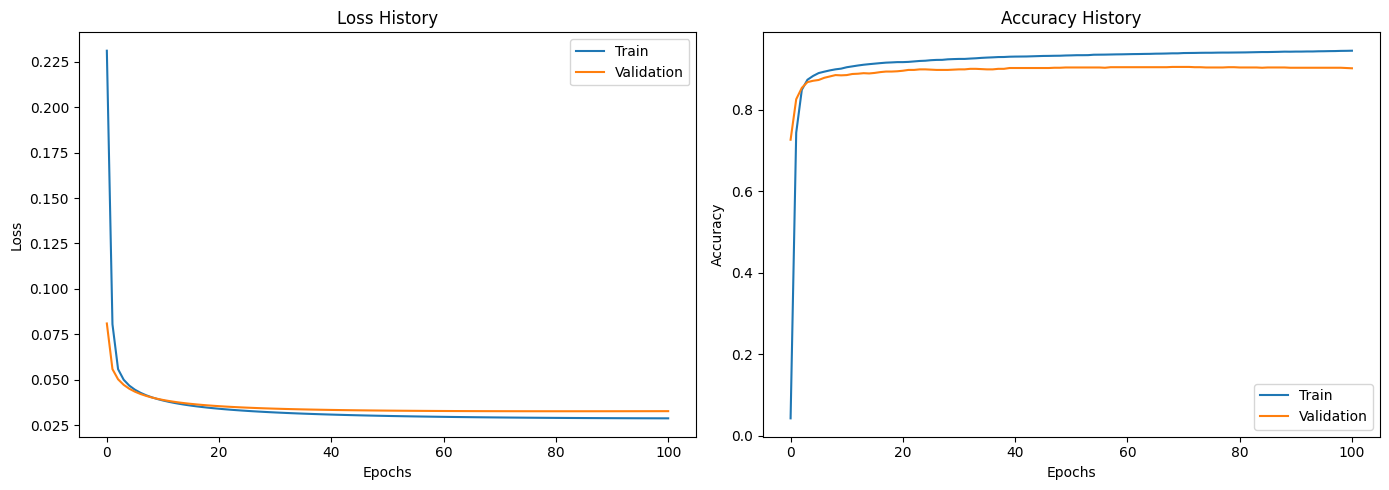


SCRATCH MODEL TEST ACCURACY: 0.9007 (90.07%)


In [59]:
import time

early_stop_mnist = EarlyStopping(patience = 20, min_delta = 0.0001)

start_time = time.time()

W_scratch, b_scratch, history_scratch = train(
    X_train_mnist_scaled, Y_train_mnist,
    X_val_mnist_scaled, Y_val_mnist,
    n_classes = 10,
    learning_rate = 0.5,
    n_epochs = 200,
    reg_type = 'l2',
    lambda_reg = 0.001,
    loss_type = 'cross_entropy',
    early_stopping = early_stop_mnist,
    verbose = True
)

scratch_time = time.time() - start_time

print(f"\nScratch model trained in {scratch_time:.2f} seconds")

plot_loss_history(history_scratch, title = "scratch Model - MNIST")

_, probs_scratch = forward_pass(X_test_mnist_scaled, W_scratch, b_scratch)
preds_scratch = np.argmax(probs_scratch, axis = 1)
acc_scratch = np.mean(preds_scratch == y_test_mnist)

print(f"\nSCRATCH MODEL TEST ACCURACY: {acc_scratch:.4f} ({acc_scratch*100:.2f}%)")

Training Scikit-Learn Model on the Dataset

In [60]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()

sklearn_model = LogisticRegression(
    multi_class = 'multinomial',
    solver = 'lbfgs',
    max_iter = 200,
    random_state = 42,
    verbose = 1,
    C = 1000
)

sklearn_model.fit(X_train_mnist_scaled, y_train_mnist)

sklearn_time = time.time() - start_time

print(f"\nScikit-learn trained in {sklearn_time:.2f} seconds")

preds_sklearn = sklearn_model.predict(X_test_mnist_scaled)
acc_sklearn = np.mean(preds_sklearn == y_test_mnist)

print(f"SCIKIT-LEARN TEST ACCURACY: {acc_sklearn:.4f} ({acc_sklearn*100:.2f}%)")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Scikit-learn trained in 7.37 seconds
SCIKIT-LEARN TEST ACCURACY: 0.8627 (86.27%)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished


BENCHMARK RESULTS - MNIST (10K subset)

Model                Accuracy        Time (s)        Speed          
Scratch Implementation  90.07%          15.96          Baseline       
Scikit-Learn          86.27%           7.37          0.46x faster
Accuracy Difference: +3.80%


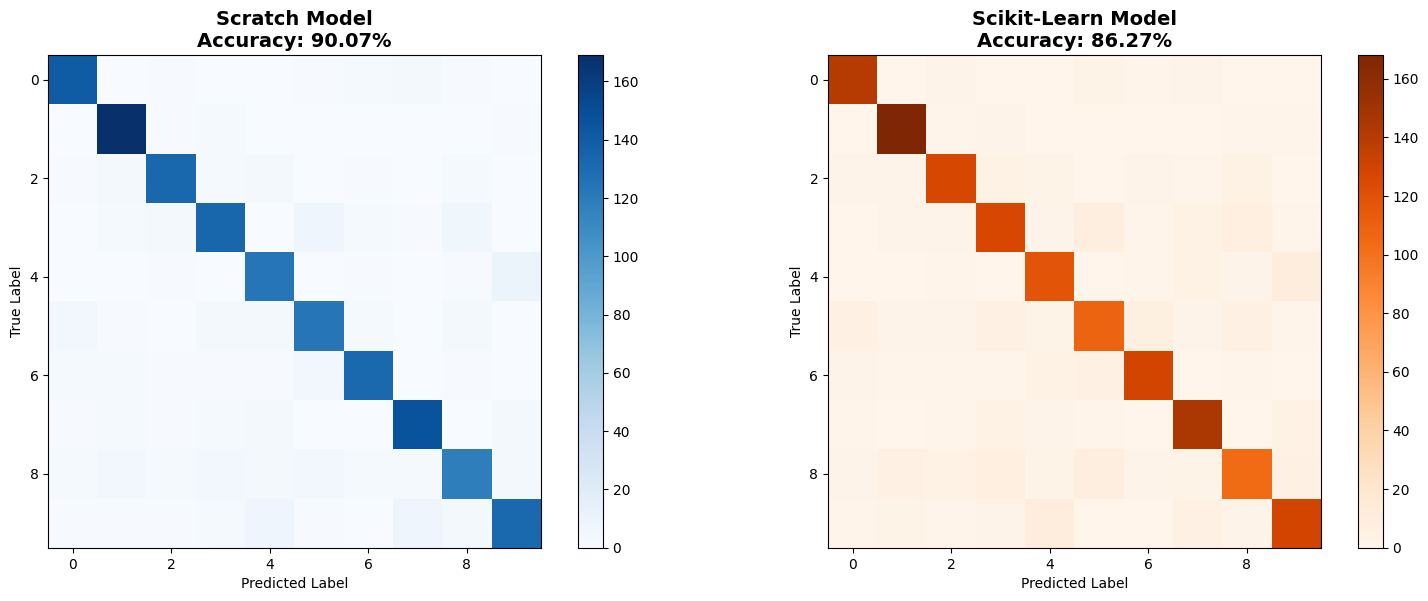

SCRATCH MODEL - Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       148
           1       0.91      0.98      0.94       173
           2       0.92      0.92      0.92       145
           3       0.89      0.86      0.88       155
           4       0.86      0.91      0.89       136
           5       0.87      0.88      0.88       140
           6       0.93      0.92      0.92       144
           7       0.92      0.92      0.92       158
           8       0.87      0.81      0.84       146
           9       0.89      0.85      0.87       155

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500

SCIKIT-LEARN - Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       148
           1       0.92      0.97      0.94       173
   

In [63]:
print("BENCHMARK RESULTS - MNIST (10K subset)")
print(f"\n{'Model':<20} {'Accuracy':<15} {'Time (s)':<15} {'Speed':<15}")
print(f"{'Scratch Implementation':<20} {acc_scratch*100:>6.2f}%{'':<8} {scratch_time:>6.2f}{'':<9} {'Baseline':<15}")
print(f"{'Scikit-Learn':<20} {acc_sklearn*100:>6.2f}%{'':<8} {sklearn_time:>6.2f}{'':<9} {sklearn_time/scratch_time:.2f}x faster")
print(f"Accuracy Difference: {(acc_scratch - acc_sklearn)*100:+.2f}%")


fig, axes = plt.subplots(1, 2, figsize = (16, 6))

cm_your = confusion_matrix(y_test_mnist, preds_scratch)
im1 = axes[0].imshow(cm_your, interpolation = 'nearest', cmap = 'Blues')
axes[0].set_title(f'Scratch Model\nAccuracy: {acc_scratch*100:.2f}%', fontsize = 14, fontweight = 'bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
plt.colorbar(im1, ax = axes[0])

cm_sklearn = confusion_matrix(y_test_mnist, preds_sklearn)
im2 = axes[1].imshow(cm_sklearn, interpolation = 'nearest', cmap = 'Oranges')
axes[1].set_title(f'Scikit-Learn Model\nAccuracy: {acc_sklearn*100:.2f}%', fontsize = 14, fontweight = 'bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.colorbar(im2, ax = axes[1])

plt.tight_layout()
plt.show()

print("SCRATCH MODEL - Classification Report")
print(classification_report(y_test_mnist, preds_scratch, target_names = [str(i) for i in range(10)]))

print("SCIKIT-LEARN - Classification Report")
print(classification_report(y_test_mnist, preds_sklearn, target_names = [str(i) for i in range(10)]))